# Movie Recommender

This notebook walks through building a simple movie recommender system using the MovieLens dataset. The goal is to understand how users’ past ratings can be used to suggest new movies they might enjoy.

I explore the data, create a user–item rating matrix, compute movie–movie similarities using cosine similarity, and generate recommendations both for individual movies and specific users. The final system is wrapped into a reusable function and later deployed as a FastAPI service.


In [1]:
# Standard library
import sys

# Third-party libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import joblib

# Local package
sys.path.append("src")
from recommender import FunkMF, recommend_similar, recommend_for_user

In [2]:
# Load the MovieLens movies metadata (movieId, title, genres) from the CSV file
movies_df = pd.read_csv("data/movies.csv")

# Display first ten rows of movies dataframe
movies_df.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


### Seperating Title and Year

In [3]:
# Extract the year from the LAST parentheses group at the end of the title
movies_df["year"] = movies_df["title"].str.extract(r"\((\d{4})\)\s*$").astype("Int64")

# Remove ONLY that final (year) part from the title, if present
movies_df["title"] = movies_df["title"].str.replace(r"\s*\(\d{4}\)\s*$", "", regex=True)

movies_df.head(10)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
5,6,Heat,Action|Crime|Thriller,1995
6,7,Sabrina,Comedy|Romance,1995
7,8,Tom and Huck,Adventure|Children,1995
8,9,Sudden Death,Action,1995
9,10,GoldenEye,Action|Adventure|Thriller,1995


In [4]:
# Load the MovieLens user–movie ratings (userId, movieId, rating, timestamp)
ratings_df = pd.read_csv("data/ratings.csv")

# Display first ten rows of ratings dataframe
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


## Data Examination

In [5]:
# Inspect schema and non-null counts for both movies and ratings DataFrames

print("=== Movies DataFrame ===")
movies_df.info()
print("\n")  

print("=== Ratings DataFrame ===")
ratings_df.info()

=== Movies DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
 3   year     9729 non-null   Int64 
dtypes: Int64(1), int64(1), object(2)
memory usage: 314.1+ KB


=== Ratings DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


### Combining Movies and Ratings

In [6]:
# Merge ratings with movie metadata so each rating includes title, year, and genres
merged_df = ratings_df.merge(movies_df, on="movieId", how="left")
merged_df.head(10)

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,964981247,Grumpier Old Men,Comedy|Romance,1995
2,1,6,4.0,964982224,Heat,Action|Crime|Thriller,1995
3,1,47,5.0,964983815,Seven (a.k.a. Se7en),Mystery|Thriller,1995
4,1,50,5.0,964982931,"Usual Suspects, The",Crime|Mystery|Thriller,1995
5,1,70,3.0,964982400,From Dusk Till Dawn,Action|Comedy|Horror|Thriller,1996
6,1,101,5.0,964980868,Bottle Rocket,Adventure|Comedy|Crime|Romance,1996
7,1,110,4.0,964982176,Braveheart,Action|Drama|War,1995
8,1,151,5.0,964984041,Rob Roy,Action|Drama|Romance|War,1995
9,1,157,5.0,964984100,Canadian Bacon,Comedy|War,1995


## Exploratory Data Analysis

Below, I will conduct an EDA examining (finish this)

### Distribution of Movie Ratings

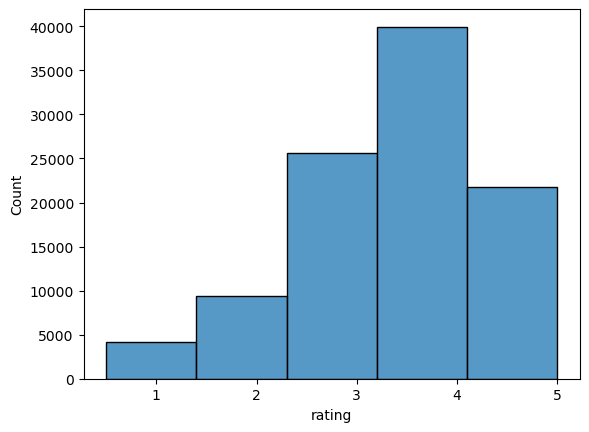

In [7]:
# Plot the distribution of rating values
sns.histplot(ratings_df["rating"], bins=5)
plt.show()

### Distribution of Movie Ratings per Users

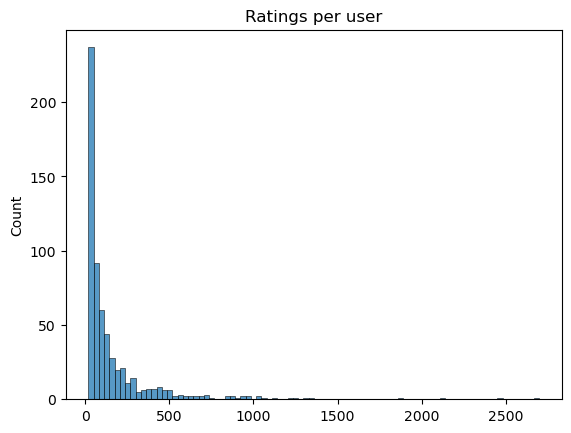

In [8]:
# Count how many ratings each user has given (activity level per user)
ratings_per_user = ratings_df.groupby("userId").size()

# Visualize how frequently users rate movies
sns.histplot(ratings_per_user)
plt.title("Ratings per user")
plt.show()


### Movies by Count

In [9]:
# Aggregate ratings per movie
movie_stats = (
    merged_df.groupby("movieId")
    .agg(
        avg_rating=("rating", "mean"),
        count=("rating", "size")
    )
    .sort_values("count", ascending=False)
)

# Merge titles back in so results include movie names
movie_stats = movie_stats.merge(
    movies_df[["movieId", "title", "year", "genres"]],
    on="movieId",
    how="left"
)

# View the top movies by rating count
movie_stats.head()


,movieId,avg_rating,count,title,year,genres
0,356,4.164134,329,Forrest Gump,1994,Comedy|Drama|Romance|War
1,318,4.429022,317,"Shawshank Redemption, The",1994,Crime|Drama
2,296,4.197068,307,Pulp Fiction,1994,Comedy|Crime|Drama|Thriller
3,593,4.161290,279,"Silence of the Lambs, The",1991,Crime|Horror|Thriller
4,2571,4.192446,278,"Matrix, The",1999,Action|Sci-Fi|Thriller


### Genres by Count

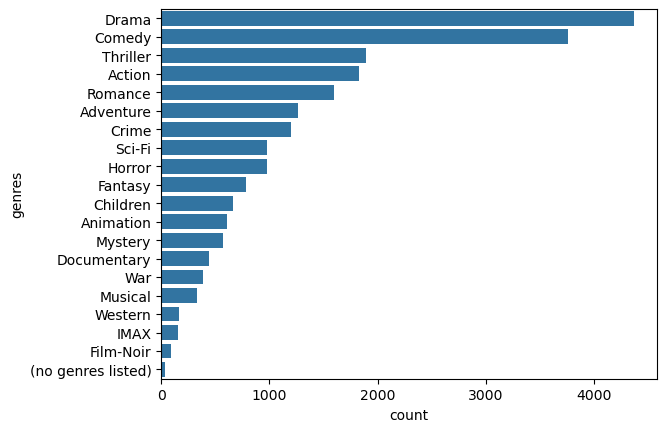

In [10]:
all_genres = movies_df['genres'].str.split('|').explode()
sns.countplot(y=all_genres, order=all_genres.value_counts().index)
plt.show()

### Genres by Rating

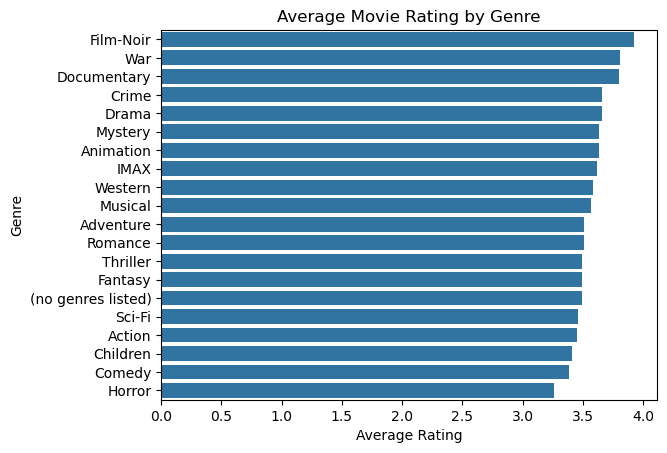

In [11]:
# Split pipe-separated genre strings and explode rows so each rating has a single genre
merged_df["genre"] = merged_df["genres"].str.split("|")
genre_df = merged_df.explode("genre")

# Compute average rating and rating count per genre
genre_ratings = (
    genre_df
    .groupby("genre")["rating"]
    .agg(avg_rating="mean", count="size")
    .sort_values("avg_rating", ascending=False)
)

# Plot: average rating per genre
sns.barplot(
    data=genre_ratings.reset_index(),
    x="avg_rating",
    y="genre"
)
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.title("Average Movie Rating by Genre")
plt.show()


### Sparsity

To understand what type of recommender model will work best, we first measure the sparsity of the user–movie rating matrix. Sparsity tells us how many entries in the matrix are empty (i.e., unrated). In most real-world datasets, users rate only a small number of items, so the vast majority of the matrix contains no ratings at all. Sparsity is formally defined as

$$
\text{Sparsity} = 1 - 
\frac{\text{Number of observed ratings}}
{\text{Number of users} \times 
\text{Number of movies}}
$$

A value closer to $1.0$ indicates that the matrix is mostly empty. This is expected because each user only interacts with a tiny fraction of all available movies, and there are far more movies in the catalog than any single user could ever rate. 


In [12]:
# Count unique users and movies to understand matrix dimensions
num_users = ratings_df["userId"].nunique()
num_movies = ratings_df["movieId"].nunique()

print("Number of unique users:", num_users)    # Total distinct users in the dataset
print("Number of unique movies:", num_movies, "\n")  # Total distinct movies rated in the dataset

# Calculate sparsity: proportion of missing entries in the user–movie matrix
sparsity = 1 - (len(ratings_df) / (num_users * num_movies))

# Display sparsity value (MovieLens datasets are typically very sparse)
print("Sparsity of user–movie matrix:", sparsity)  # Fraction of user–movie pairs with no rating


Number of unique users: 610
Number of unique movies: 9724 

Sparsity of user–movie matrix: 0.9830003169443864


#### Sparsity Analysis 
In our case, the sparsity is approximately 0.98, meaning that about 98% of all possible user–movie pairs have no rating. This high level of sparsity is typical for recommendation datasets and motivates the use of item–item collaborative filtering and matrix factorization methods, which are better suited to learning from sparse data than simple user–user similarity approaches.

## Collaborative Filtering 

### User Item Matrix 

Below, I will create the user item matrix, which which represents how each user rated each movie. 

- **Rows correspond to users**
- **Columns correspond to movies**
- **Entries contain the rating a user gave a movie**
- **Empty (unrated) entries are filled with 0**

This matrix is the core structure used by collaborative filtering models. It allows us to compare movies based on how users rated them and to compute similarity scores between items. Because the matrix is extremely sparse, it also highlights why certain approaches, such as item–item collaborative filtering and matrix factorization, are more effective than user–user similarity methods for this dataset.


In [13]:
# Create the user–item rating matrix (rows = users, columns = movies)
user_item_matrix = ratings_df.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
)

# Fill missing ratings with 0 for computational purposes
user_item_matrix = user_item_matrix.fillna(0)

# Show the first 10 rows of the matrix
display(user_item_matrix.head(10))

# Print matrix shape with clear labels
rows, cols = user_item_matrix.shape
print(" ")
print(f"User–Item Matrix Shape: {rows} rows × {cols} columns")

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,5.0,3.0,5.0,4.0,4.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 
User–Item Matrix Shape: 610 rows × 9724 columns


### Cosine Similarity

The next step is to calculate the cosine similarity between movies. After constructing the user–item matrix, I transpose it so that each **row represents a movie** and each **column represents a user**. In this format, every movie becomes a vector of user ratings.

Cosine similarity measures how similar two movies are by comparing the angle between their rating vectors, regardless of their absolute magnitude. It is defined as:

$$
\text{sim}(i, j) = 
\frac{\mathbf{r}_i \cdot \mathbf{r}_j}
{\lVert \mathbf{r}_i \rVert \, \lVert \mathbf{r}_j \rVert}
$$

Here,  
- $\mathbf{r}_i$ is the **rating vector for movie \(i\)** — one value per user.  
- $\mathbf{r}_j$ is the **rating vector for movie \(j\)** — again, one value per user.  

Each vector contains the ratings given by *all users*, with zeros (or missing values) where a user did not rate the movie.

A similarity score close to **1** means two movies are rated similarly by the same users (strong similarity), while a score close to **0** indicates little or no relationship. Computing this for every pair of movies produces the item–item similarity matrix, which forms the basis of the item-based collaborative filtering recommender used next.


In [14]:
# Transpose the user–item matrix so rows become movies and columns become users
item_user_matrix = user_item_matrix.T

# Compute cosine similarity between all pairs of movies (item–item similarity)
item_similarity = cosine_similarity(item_user_matrix)

# Wrap the similarity array in a DataFrame for easier indexing by movieId
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=item_user_matrix.index,   # movieIds as row labels
    columns=item_user_matrix.index  # movieIds as column labels
)

# Display item–item similarity matrix (movieId × movieId)
display(item_similarity_df.head(10))

# Print matrix shape with clear labels
rows, cols = item_similarity_df.shape
print(" ")
print(f"Item Matrix Similarity Shape: {rows} rows × {cols} columns")

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,0.376316,0.297009,0.284257,0.089685,0.298969,1.000000,0.244105,0.147562,0.214088,0.386414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.277491,0.228576,0.402831,0.275035,0.474002,0.244105,1.000000,0.273757,0.162000,0.238949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.131629,0.172498,0.313434,0.158022,0.283523,0.147562,0.273757,1.000000,0.000000,0.189867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9,0.232586,0.044835,0.304840,0.000000,0.335058,0.214088,0.162000,0.000000,1.000000,0.048611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


 
Item Matrix Similarity Shape: 9724 rows × 9724 columns


In [15]:
# Retrieve and display the 10 movies with the highest similarity scores to movieId = 1
item_similarity_df[1].sort_values(ascending=False).head(10)

movieId
1       1.000000
3114    0.572601
480     0.565637
780     0.564262
260     0.557388
356     0.547096
364     0.541145
1210    0.541089
648     0.538913
1265    0.534169
Name: 1, dtype: float64

https://pub.towardsai.net/a-movie-recommendation-system-in-python-from-scratch-e0dd681a68fc

### Finding Movies Similar to a Given Title

This section shows how to get movies that are most similar to a chosen film. The recommendations come from the item–item similarity matrix, which is built using **cosine similarity** to compare how users rated each pair of movies. By focusing on films with the most similar rating patterns, we can surface the closest matches for any movie you pick.


In [16]:
recommend_similar("Toy Story", movies_df, item_similarity_df, n=5)

,movieId,title,year,genres,similarity
0,3114,Toy Story 2,1999,Adventure|Animation|Children|Comedy|Fantasy,0.572601
1,480,Jurassic Park,1993,Action|Adventure|Sci-Fi|Thriller,0.565637
2,780,Independence Day (a.k.a. ID4),1996,Action|Adventure|Sci-Fi|Thriller,0.564262
3,260,Star Wars: Episode IV - A New Hope,1977,Action|Adventure|Sci-Fi,0.557388
4,356,Forrest Gump,1994,Comedy|Drama|Romance|War,0.547096


### Personalized Movie Recommendations (Unseen Movies)

This section generates personalized recommendations for a specific user. The system looks at all the movies the user has already rated and finds new films that are **most similar** to those preferences using the item–item cosine similarity matrix.

For each unseen movie, the model predicts how much the user would enjoy it by taking a **weighted average of the user’s past ratings**, where the weights come from cosine similarity. Movies that are both highly similar *and* highly rated by the user contribute more to the predicted score.

The prediction formula is:

$$
\hat{r}_{um} =
\frac{
\sum\limits_{i \in R(u)} \text{sim}(m, i)\,\times\, r_{ui}
}{
\sum\limits_{i \in R(u)} |\text{sim}(m, i)|
}
$$

Where:

- $R(u)$: all movies the user has already rated  
- $r_{ui}$: the user’s rating on movie $i$  
- $ \text{sim}(m, i)$: cosine similarity between movie $m$ and movie $i$  
- The denominator keeps the prediction scale stable by normalizing the weighted sum  

This ensures that recommended movies are **ones the user hasn’t seen yet**, but closely align with the patterns in their previous ratings.


In [17]:
recs = recommend_for_user(
    1,
    movies_df,
    user_item_matrix,
    item_similarity_df,
    n_recs=10
)

recs

,movieId,title,year,genres,predicted_rating
0,3899,Circus,2000,Crime|Drama|Thriller,5.0
1,1140,Entertaining Angels: The Dorothy Day Story,1996,Drama,5.0
2,1519,Broken English,1996,Drama,5.0
3,2896,Alvarez Kelly,1966,Western,5.0
4,3106,Come See the Paradise,1990,Drama|Romance,5.0
5,6158,"Jungle Book 2, The",2003,Animation|Children,5.0
6,26366,Harlan County U.S.A.,1976,Documentary,5.0
7,44633,"Devil and Daniel Johnston, The",2005,Documentary,5.0
8,58309,War Dance,2007,Documentary,5.0
9,63239,Cinderella,1997,Children|Fantasy|Musical|Romance,5.0


## Matrix Factorization

Matrix factorization is a powerful recommendation technique that represents users and items in a shared latent feature space. The predicted rating $\hat{r}_{ui}$ for user $u$ and item $i$ is defined as

$$
\hat{r}_{ui} = \mu + b_u + b_i + q_i^\top p_u.
$$

where:

- **$\mu$** is the global average rating across all users and items.
- **$b_u$** is the *user bias*, capturing how much user $u$ tends to rate above or below the global mean.
- **$b_i$** is the *item bias*, capturing how much item $i$ tends to be rated above or below the global mean.
- **$q_i^\top p_u$** is the dot product between the user’s latent factor vector $p_u$ and the item’s latent factor vector $q_i$, representing how well the user’s preferences align with the item's characteristics.

---

To estimate all unknown parameters, we minimize the regularized squared error over the training set $R_{\text{train}}$:

$$
\sum_{(u,i) \in R_{\text{train}}}
(r_{ui} - \hat{r}_{ui})^2
\;+\;
\lambda \left(
b_u^2 + b_i^2 + \| p_u \|^2 + \| q_i \|^2
\right).
$$

Here, $\lambda$ controls the strength of regularization.

---

### Stochastic Gradient Descent Updates

We optimize this loss using stochastic gradient descent (SGD). For each observed rating $r_{ui}$, we compute the prediction error

$$
e_{ui} = r_{ui} - \hat{r}_{ui},
$$

and update each parameter as follows:

$$
b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u),
$$

$$
b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i),
$$

$$
p_u \leftarrow p_u + \gamma (e_{ui} \, q_i - \lambda p_u),
$$

$$
q_i \leftarrow q_i + \gamma (e_{ui} \, p_u - \lambda q_i).
$$

Here, $\gamma$ is the learning rate. 

**Note:** the multiplication above is scalar multiplication, not a cross product.

---


**Sources**

https://rpubs.com/Argaadya/recommender-svdf

https://surprise.readthedocs.io/en/stable/matrix_factorization.html


### Initialize and Fit Model

In [18]:
# Create the FunkMF model with chosen parameters
model = FunkMF(
    n_factors=20,
    n_epochs=10,
    lr=0.01,
    reg=0.02,
    random_state=42
)

# Train the model on the ratings data
model.fit(ratings_df)

Epoch 1/10 - MSE: 0.8789
Epoch 2/10 - MSE: 0.7846
Epoch 3/10 - MSE: 0.7513
Epoch 4/10 - MSE: 0.7294
Epoch 5/10 - MSE: 0.7116
Epoch 6/10 - MSE: 0.6954
Epoch 7/10 - MSE: 0.6793
Epoch 8/10 - MSE: 0.6620
Epoch 9/10 - MSE: 0.6428
Epoch 10/10 - MSE: 0.6219


### Rating Prediction

In [19]:
# Predict how user 1 would rate movie 9
model.predict(user_id=1, movie_id=9)

3.8245678603608178

### Recommendations

In [20]:
# Get the top 40 recommended movies for user 1
recs = model.recommend_top_n(user_id=1, movies_df=movies_df, n=40)

# Print each recommended movie with its ID and predicted rating
for title, mid, score in recs:
    print(f"{title} (id={mid}): {score:.2f}")

Shawshank Redemption, The (id=318): 5.00
Schindler's List (id=527): 5.00
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (id=750): 5.00
Godfather, The (id=858): 5.00
Rear Window (id=904): 5.00
Casablanca (id=912): 5.00
Sunset Blvd. (a.k.a. Sunset Boulevard) (id=922): 5.00
Streetcar Named Desire, A (id=1104): 5.00
Wallace & Gromit: The Wrong Trousers (id=1148): 5.00
One Flew Over the Cuckoo's Nest (id=1193): 5.00
Lawrence of Arabia (id=1204): 5.00
Apocalypse Now (id=1208): 5.00
Godfather: Part II, The (id=1221): 5.00
Amadeus (id=1225): 5.00
Touch of Evil (id=1248): 5.00
Great Escape, The (id=1262): 5.00
Amelie (Fabuleux destin d'Amélie Poulain, Le) (id=4973): 5.00
City of God (Cidade de Deus) (id=6016): 5.00
Departed, The (id=48516): 5.00
There Will Be Blood (id=56782): 5.00
Grand Day Out with Wallace and Gromit, A (id=1223): 4.99
Forrest Gump (id=356): 4.99
Life Is Beautiful (La Vita è bella) (id=2324): 4.99
Usual Suspects, The (id=50): 4.99
In the Name of the Fath

### Saving

In [21]:
joblib.dump(movies_df, "artifacts/movies_df.pkl")
joblib.dump(user_item_matrix, "artifacts/user_item_matrix.pkl")
joblib.dump(item_similarity_df, "artifacts/item_similarity_df.pkl")
joblib.dump(ratings_df, "artifacts/ratings_df.pkl")

['artifacts/ratings_df.pkl']